In [1]:
%pylab inline

import pandas
import scipy.integrate as si

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Step 1: Get Data

with open("../data/jla_data_toconvert.txt", 'r') as jlaraw:
    jlarawstr = jlaraw.read()
    
jlarawlines = jlarawstr.split("\n")

i = 0
headings = []
while (jlarawlines[i] != r"#end"):
    thisline = jlarawlines[i]
    i+=1
    if thisline[0] == r"@":
        continue
    else:
        headings.append(thisline[1:-1])
        
#SNTYPE, SURVEY and name have str type but all others have float type
types = []

for heading in headings:  # this doesn't actually work bro
    if heading in ['SNTYPE', 'SURVEY', 'name', 'LCSRC_0']:
        types.append(np.str_)
    else:
        types.append(np.float_)

# now we actually need to parse data into an array. This is going to be very messy. Sorry, future me if this breaks.
fulllist = []

for line in jlarawlines:
    if line:
        if (line[0]=='#') or (line[0]=='@'):
            continue
        else:
            thisarry = np.empty_like(types)
            thislist = line.split("  ")
            for i in range(len(thisarry)):
                thisarry[i] = thislist[i]
        
            fulllist.append(thisarry)
            

fullarray = np.array(fulllist)

jla = pandas.DataFrame(data=fullarray, columns=headings)

# correct SDSS data

corrected = array(jla.loc[jla['SURVEY']=='SDSS']['RA'], dtype=float) + 180
jla.loc[jla['SURVEY']=='SDSS', 'RA'] = corrected

# now convert to different data types

for heading in headings:
    if heading in ['SNTYPE', 'SURVEY', 'name', 'LCSRC_0']:
        jla[heading] = jla[heading].astype(str)
    else:
        jla[heading] = jla[heading].astype(float)


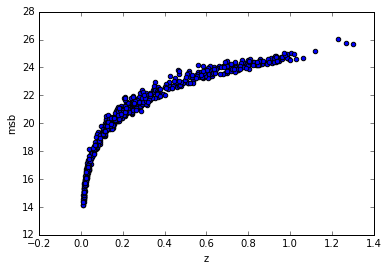

In [3]:
# test everything went okay

jla.plot(kind='scatter', x='z', y='msb')

Will have 
+ params[0] = lpeak
+ params[1] = omegaM


In [4]:
# Cosmology

zlim = 0.075

import theano
import theano.tensor as T

H0 = 2.27e-18
sol = 3e8

def H(z, params):
    '''Implements the Friedmann equation'''
    b = params[1]
    model = (b)*((1+z)**3) + (1-b)
    return H0*sqrt(model)


def integrand(z, params):
    '''Pass-throguh inverse for H(z)'''
    return 1/H(z, params)


def lum(z, params):
    if z>zlim:
        output = si.quad(integrand, 0, z, args=(params))
        val = output[0]
    else:
        val = z/H0
    return sol * val


def flux(z, params):
    lp = 1e39*params[0]
    model = lp/((4*pi)*(((1+z)*(lum(z, params)))**2))
    return model


def mc(name, params):
    '''Calculated magnitude'''
    # select values out of pandas dataframe
    z = float(jla.loc[jla['name']==name]['z'])
    #ra = float(jla.loc[jla['name']==name]['RA'])
    #dec = float(jla.loc[jla['name']==name]['DEC'])
    
    return (-20.45 - 2.5*log10(1e-4 * flux(z, params)))


def mt(name):
    '''True magnitude'''
    return jla.loc[jla['name']==name]['msb']



In [5]:
# vectorize useful functions

vmc = vectorize(mc)
vmc.excluded.add(1)
vmt = vectorize(mt)

In [6]:
'''import pymc

X = jla['name']
Y = vmt(X)
SD = jla['msbe']


omegaM = pymc.Uniform('omegaM', 0, 0.5, value=0.3)
leff = pymc.Uniform('leff', 0, 100, value=2)

@pymc.deterministic(plot=False)
def mymsb(n=X, M=omegaM, L=leff):
    return vmc(n, [L, M])

y = pymc.Normal('y', mu=mymsb, tau=1./(SD)**2, value=Y, observed=True)'''

"import pymc\n\nX = jla['name']\nY = vmt(X)\nSD = jla['msbe']\n\n\nomegaM = pymc.Uniform('omegaM', 0, 0.5, value=0.3)\nleff = pymc.Uniform('leff', 0, 100, value=2)\n\n@pymc.deterministic(plot=False)\ndef mymsb(n=X, M=omegaM, L=leff):\n    return vmc(n, [L, M])\n\ny = pymc.Normal('y', mu=mymsb, tau=1./(SD)**2, value=Y, observed=True)"

In [7]:
'''params = [4, 0.3]
mexp = vmc(X, params)'''

'params = [4, 0.3]\nmexp = vmc(X, params)'

In [8]:
'''R = pymc.MCMC([omegaM, leff, y])'''

'R = pymc.MCMC([omegaM, leff, y])'

In [9]:
'''R.sample(1500)'''

'R.sample(1500)'

In [10]:
'''from pymc.Matplot import plot

plot(R)'''

'from pymc.Matplot import plot\n\nplot(R)'

In [18]:
# fix lpeak using low-z data

import pymc

lowz = jla.loc[jla['z']<1.5]

X = lowz['name']
Y = vmt(X)
SD = lowz['msbe']


leff = pymc.Uniform('leff', lower=3, upper=5)

@pymc.deterministic(plot=False)
def mymsb(n=X, L=leff):
    return vmc(n, [L, 0.295])  #om doesn't actually matter here

y = pymc.Normal('y', mu=mymsb, tau=1./(SD)**2, value=Y, observed=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 3050.6 secPlotting leff


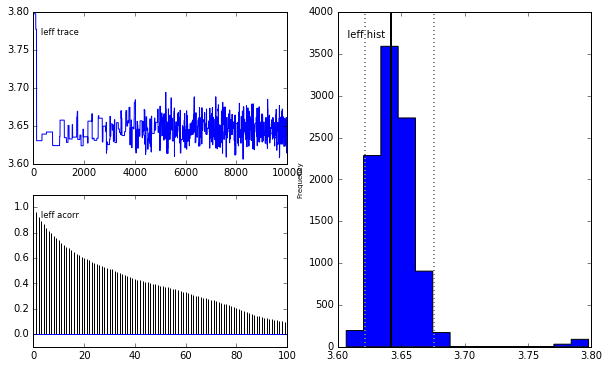

In [19]:
R = pymc.MCMC([leff, y])
R.sample(10000)



from pymc.Matplot import plot as mplr

mplr(R)

In [13]:
lpeak = leff.value

In [14]:
highz = jla.loc[jla['z']>=zlim]

X2 = highz['name']
Y2 = vmt(X2)
SD2 = highz['msbe']

omegaM = pymc.Uniform('omegaM', lower=0, upper=0.5)

@pymc.deterministic(plot=False)
def mymsb2(n=X2, M=omegaM):
    return vmc(n, [lpeak, M])  #om doesn't actually matter here

y2 = pymc.Normal('y2', mu=mymsb2, tau=1./(SD2)**2, value=Y2, observed=True)

 [-----------------100%-----------------] 3000 of 3000 complete in 505.9 secPlotting omegaM


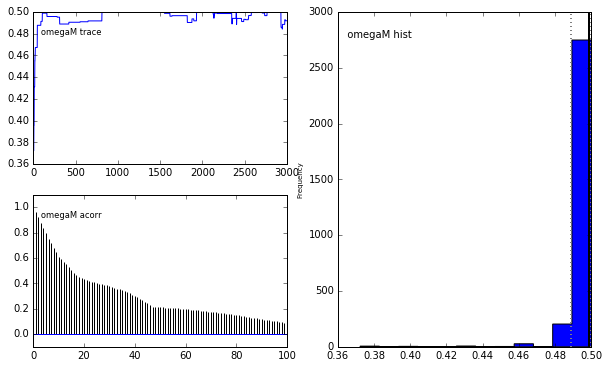

In [15]:
M = pymc.MCMC([omegaM, y])
M.sample(3000)



from pymc.Matplot import plot as mplr

mplr(M)

In [16]:
from scipy.optimize import curve_fit

In [17]:
def mccf(name, x, y):
    '''Passthrough'''
    params = [x,y]
    return vmc(name, params)

curve_fit(mccf, jla['name'], vmt(jla['name']), p0=([4, 0.3]), sigma=jla['msbe'], absolute_sigma=True)

(array([ 3.37677599,  0.46610978]), array([[ 0.00053569, -0.00026821],
        [-0.00026821,  0.00019164]]))